In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import random
from scipy.stats import pearsonr

In [2]:
# import data
base = f"/ptmp/sfassnacht/ratproject/15.07."
anat=nib.load(f"{base}/anatomy.nii.gz")
anat2func=sitk.ReadTransform(f"{base}/anatomy_to_func.txt")


In [3]:
anat_load = anat.get_fdata()
anat_load.shape


(256, 256, 32)

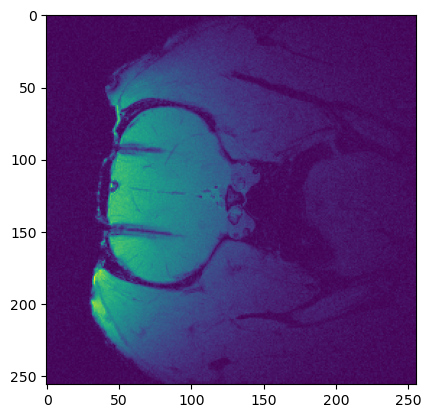

In [4]:
test = anat_load[:,:,25]
plt.imshow(test)
plt.show()

In [5]:
func=nib.load(f"{base}/cleaned_mc_func.nii.gz")

func_ts = func.get_fdata()



In [6]:
func_ts.shape
#type(func_ts)



(64, 64, 16, 2400)

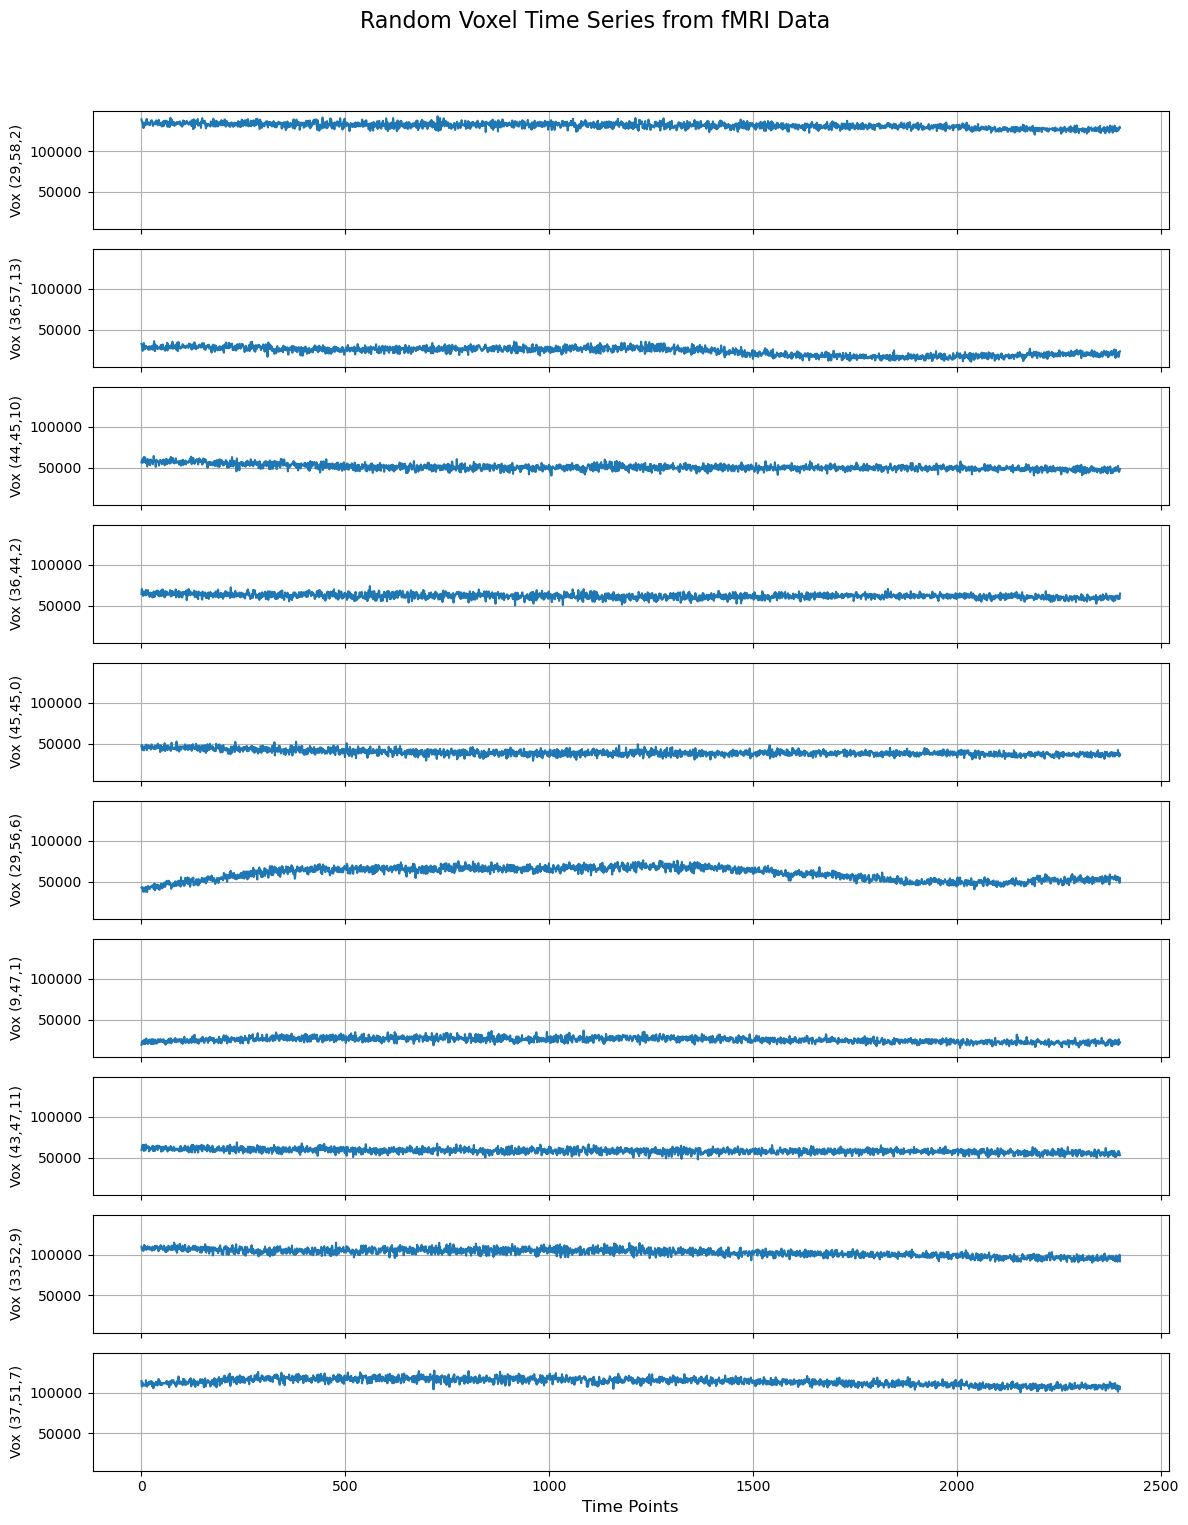

In [7]:
# Make figure larger and prepare 10 subplots stacked vertically
fig, axs = plt.subplots(10, sharex=True, sharey=True, figsize=(12, 16))
fig.suptitle("Random Voxel Time Series from fMRI Data", fontsize=16)

x_dim, y_dim, z_dim, t_dim = func_ts.shape
nonzero_voxels = np.argwhere(np.mean(func_ts, axis=3) > 0)

for i in range(10):
    rand_idx = random.choice(nonzero_voxels)
    x, y, z = rand_idx
    time_series = func_ts[x, y, z, :]

    axs[i].plot(time_series)
    axs[i].set_ylabel(f"Vox ({x},{y},{z})", fontsize=10)
    axs[i].grid(True)

# Only label x-axis once at bottom
axs[-1].set_xlabel("Time Points", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()

In [8]:
roi_mask_R = sitk.ReadImage(f"{base}/roi_sero_15um.nii.gz", sitk.sitkUInt8)
roi_mask_L = sitk.ReadImage(f"{base}/roi_sero_150um.nii.gz", sitk.sitkUInt8)
func_4d = sitk.ReadImage(f"{base}/cleaned_mc_func.nii.gz")
func_3d = sitk.Extract(func_4d, size=func_4d.GetSize()[:3] + (0,), index=(0, 0, 0, 0))

In [9]:
resampled_mask = sitk.Resample(
    roi_mask_R,
    func_3d,
    anat2func,
    sitk.sitkNearestNeighbor,
    0,
    roi_mask_R.GetPixelID()
)

In [10]:
sitk.WriteImage(resampled_mask, f"{base}/roi_mask_in_func_space_R.nii.gz")

In [11]:
func_4d = sitk.ReadImage(f"{base}/cleaned_mc_func.nii.gz")
func_3d = sitk.Extract(func_4d, size=func_4d.GetSize()[:3] + (0,), index=(0, 0, 0, 0))

resampled_mask = sitk.Resample(
    roi_mask_L,
    func_3d,
    anat2func,
    sitk.sitkNearestNeighbor,
    0,
    roi_mask_L.GetPixelID()
)

sitk.WriteImage(resampled_mask, f"{base}/roi_mask_in_func_space_L.nii.gz")

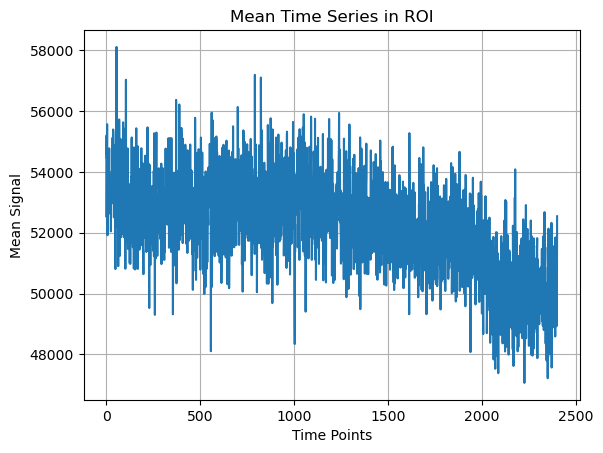

In [12]:
mask_img = nib.load(f"{base}/roi_mask_in_func_space_R.nii.gz")
mask_data = mask_img.get_fdata()  # Shape: (x, y, z)

# Ensure mask is binary (0/1)
mask_data = mask_data > 0

# Reshape functional image to (num_voxels, time)
flat_func = func_ts[mask_data]  # shape: (num_voxels_in_roi, time)

# Compute mean time series
mean_ts = flat_func.mean(axis=0)  # average over voxels, keep time axis

# Plot it
plt.plot(mean_ts)
plt.title("Mean Time Series in ROI")
plt.xlabel("Time Points")
plt.ylabel("Mean Signal")
plt.grid(True)
plt.show()

In [13]:
X, Y, Z, T = func_ts.shape

# Extract seed (ROI) mean time series
seed_ts = func_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_R = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = func_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_R[x, y, z] = corr
            else:
                corr_map_R[x, y, z] = 0  # or np.nan


In [14]:
z_map_R = np.arctanh(corr_map_R)

In [15]:
from nibabel import Nifti1Image

corr_img = Nifti1Image(corr_map_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_R.nii.gz")


In [16]:
# lets split the time series into its v3 phases

func_ts.shape
stage = ["pre_injection", "injection", "post_injection"]

pre_injection_ts = func_ts[:,:,:,0:600]
injection_ts = func_ts[:,:,:,601:1200]
post_injection_ts = func_ts[:,:,:,1201:]

pre_injection_ts.shape


(64, 64, 16, 600)

In [17]:
X, Y, Z, T = pre_injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = pre_injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_pre_R = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = pre_injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_pre_R[x, y, z] = corr
            else:
                corr_map_pre_R[x, y, z] = 0  # or np.nan

In [18]:
z_map_pre_R = np.arctanh(corr_map_pre_R)


corr_img = Nifti1Image(corr_map_pre_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_pre_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_pre_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_pre_R.nii.gz")

In [19]:
X, Y, Z, T = injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_inj_R = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_inj_R[x, y, z] = corr
            else:
                corr_map_inj_R[x, y, z] = 0  # or np.nan

In [20]:
z_map_inj_R = np.arctanh(corr_map_inj_R)


corr_img = Nifti1Image(corr_map_inj_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_inj_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_inj_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_inj_R.nii.gz")

In [21]:
X, Y, Z, T = post_injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = post_injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_post_R = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = post_injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_post_R[x, y, z] = corr
            else:
                corr_map_post_R[x, y, z] = 0  # or np.nan



In [22]:
z_map_post_R = np.arctanh(corr_map_post_R)


corr_img = Nifti1Image(corr_map_post_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_post_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_post_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_post_R.nii.gz")

In [36]:
ratio_1_R =  corr_map_inj_R / corr_map_pre_R

z_map_1_R = np.arctanh(ratio_1_R)


corr_img = Nifti1Image(ratio_1_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_1_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_1_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_1_R.nii.gz")

/tmp/ipykernel_453491/3860217018.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_1_R =  corr_map_inj_R / corr_map_pre_R
/tmp/ipykernel_453491/3860217018.py:3: RuntimeWarning: invalid value encountered in arctanh
  z_map_1_R = np.arctanh(ratio_1_R)


##### Left hemisphere

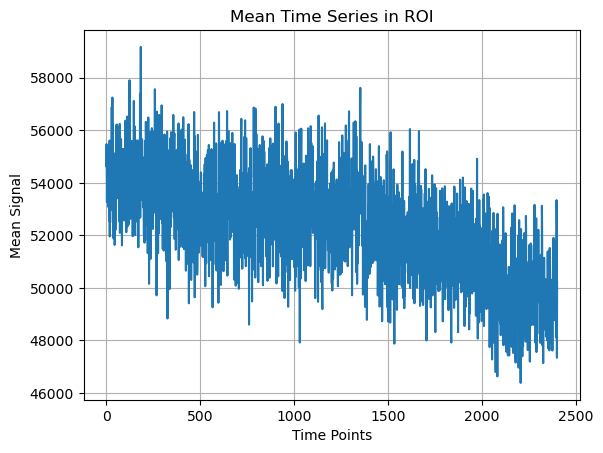

In [24]:
mask_img = nib.load(f"{base}/roi_mask_in_func_space_L.nii.gz")
mask_data = mask_img.get_fdata()  # Shape: (x, y, z)

# Ensure mask is binary (0/1)
mask_data = mask_data > 0

# Reshape functional image to (num_voxels, time)
flat_func = func_ts[mask_data]  # shape: (num_voxels_in_roi, time)

# Compute mean time series
mean_ts = flat_func.mean(axis=0)  # average over voxels, keep time axis

# Plot it
plt.plot(mean_ts)
plt.title("Mean Time Series in ROI")
plt.xlabel("Time Points")
plt.ylabel("Mean Signal")
plt.grid(True)
plt.show()

In [25]:
X, Y, Z, T = func_ts.shape

# Extract seed (ROI) mean time series
seed_ts = func_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_L = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = func_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_L[x, y, z] = corr
            else:
                corr_map_L[x, y, z] = 0  # or np.nan

z_map_L = np.arctanh(corr_map_L)


In [26]:
corr_img = Nifti1Image(corr_map_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_L.nii.gz")

In [27]:
func_ts.shape
stage = ["pre_injection", "injection", "post_injection"]

pre_injection_ts = func_ts[:,:,:,0:600]
injection_ts = func_ts[:,:,:,601:1200]
post_injection_ts = func_ts[:,:,:,1201:]

pre_injection_ts.shape


(64, 64, 16, 600)

In [28]:
X, Y, Z, T = pre_injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = pre_injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_pre_L = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = pre_injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_pre_L[x, y, z] = corr
            else:
                corr_map_pre_L[x, y, z] = 0  # or np.nan

In [29]:
z_map_pre_L = np.arctanh(corr_map_pre_L)


corr_img = Nifti1Image(corr_map_pre_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_pre_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_pre_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_pre_L.nii.gz")

In [30]:
X, Y, Z, T = injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_inj_L = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_inj_L[x, y, z] = corr
            else:
                corr_map_inj_L[x, y, z] = 0  # or np.nan

In [31]:
z_map_inj_L = np.arctanh(corr_map_inj_L)


corr_img = Nifti1Image(corr_map_inj_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_inj_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_inj_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_inj_L.nii.gz")

In [32]:
X, Y, Z, T = post_injection_ts.shape

# Extract seed (ROI) mean time series
seed_ts = post_injection_ts[mask_data].mean(axis=0)  # shape: (T,)

# Initialize output correlation map
corr_map_post_L = np.zeros((X, Y, Z), dtype=np.float32)

# Reshape for vectorized correlation (slower but clearer method below)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            voxel_ts = post_injection_ts[x, y, z, :]
            if np.std(voxel_ts) > 0:  # avoid flat lines
                corr, _ = pearsonr(seed_ts, voxel_ts)
                corr_map_post_L[x, y, z] = corr
            else:
                corr_map_post_L[x, y, z] = 0  # or np.nan



In [33]:
z_map_post_L = np.arctanh(corr_map_post_L)


corr_img = Nifti1Image(corr_map_post_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_post_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_post_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_post_L.nii.gz")

In [34]:
ratio_1_L =  corr_map_inj_L / corr_map_pre_L

z_map_ratio_1_L = np.arctanh(ratio_1_L)


corr_img = Nifti1Image(ratio_1_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_1_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_1_L.nii.gz")

/tmp/ipykernel_453491/3467293027.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_1_L =  corr_map_inj_L / corr_map_pre_L
/tmp/ipykernel_453491/3467293027.py:3: RuntimeWarning: invalid value encountered in arctanh
  z_map_ratio_1_L = np.arctanh(ratio_1_L)


### LR-contrasts


In [35]:
ratio_2_R =  corr_map_post_R / corr_map_pre_R

z_map_2_R = np.arctanh(ratio_1_R)


corr_img = Nifti1Image(ratio_2_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_2_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_2_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_2_R.nii.gz")

/tmp/ipykernel_453491/3481160337.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_2_R =  corr_map_post_R / corr_map_pre_R
/tmp/ipykernel_453491/3481160337.py:3: RuntimeWarning: invalid value encountered in arctanh
  z_map_2_R = np.arctanh(ratio_1_R)


In [38]:
ratio_2_L =  corr_map_post_L / corr_map_pre_L

z_map_2_L = np.arctanh(ratio_2_L)


corr_img = Nifti1Image(ratio_2_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_2_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_2_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_2_L.nii.gz")

/tmp/ipykernel_453491/1473800638.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_2_L =  corr_map_post_L / corr_map_pre_L
/tmp/ipykernel_453491/1473800638.py:3: RuntimeWarning: invalid value encountered in arctanh
  z_map_2_L = np.arctanh(ratio_2_L)


In [39]:
ratio_3_R =  corr_map_post_R / corr_map_inj_R

z_map_3_R = np.arctanh(ratio_3_R)


corr_img = Nifti1Image(ratio_3_R, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_3_R.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_3_R, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_3_R.nii.gz")

/tmp/ipykernel_453491/3627001941.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_3_R =  corr_map_post_R / corr_map_inj_R
/tmp/ipykernel_453491/3627001941.py:3: RuntimeWarning: invalid value encountered in arctanh
  z_map_3_R = np.arctanh(ratio_3_R)


In [40]:
ratio_3_L =  corr_map_post_L / corr_map_inj_L

z_map_3_L = np.arctanh(ratio_3_L)


corr_img = Nifti1Image(ratio_3_L, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_3_L.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_3_L, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_3_L.nii.gz")

/tmp/ipykernel_453491/422763285.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_3_L =  corr_map_post_L / corr_map_inj_L
/tmp/ipykernel_453491/422763285.py:3: RuntimeWarning: invalid value encountered in arctanh
  z_map_3_L = np.arctanh(ratio_3_L)


### To-Do's July, 28th

- check z-scoring (what does it do exactly?)
- upload the script to Github (after cleaning)
- seed-based FC for left hemi
- do ratios instead of differences
- 

### Left vs. right contrasts

In [42]:
ratio_4 = corr_map_pre_L / corr_map_pre_R
z_map_4 = np.arctanh(ratio_4)

corr_img = Nifti1Image(ratio_4, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_4.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_4, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_4.nii.gz")

/tmp/ipykernel_453491/1053541974.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_4 = corr_map_pre_L / corr_map_pre_R
/tmp/ipykernel_453491/1053541974.py:2: RuntimeWarning: invalid value encountered in arctanh
  z_map_4 = np.arctanh(ratio_4)


In [43]:
ratio_5 = corr_map_inj_L / corr_map_inj_R
z_map_5 = np.arctanh(ratio_5)

corr_img = Nifti1Image(ratio_5, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_5.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_5, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_5.nii.gz")

/tmp/ipykernel_453491/2826356422.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_5 = corr_map_inj_L / corr_map_inj_R
/tmp/ipykernel_453491/2826356422.py:2: RuntimeWarning: invalid value encountered in arctanh
  z_map_5 = np.arctanh(ratio_5)


In [44]:
ratio_6 = corr_map_post_L / corr_map_post_R
z_map_6 = np.arctanh(ratio_6)

corr_img = Nifti1Image(ratio_6, affine=func.affine)
corr_img.to_filename(f"{base}/seed_fc_corr_map_6.nii.gz")

# Or save z-transformed map
z_img = Nifti1Image(z_map_6, affine=func.affine)
z_img.to_filename(f"{base}/seed_fc_z_map_6.nii.gz")

/tmp/ipykernel_453491/4063522994.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_6 = corr_map_post_L / corr_map_post_R
/tmp/ipykernel_453491/4063522994.py:2: RuntimeWarning: invalid value encountered in arctanh
  z_map_6 = np.arctanh(ratio_6)
